In [ ]:
# Required Libraries
import numpy  as np
import random
import os
resultant_fom=[]
# Function: Initialize Variables
def initial_position(swarm_size, min_values, max_values, target_function):
    position = np.zeros((swarm_size, len(min_values)+1))
    for i in range(0, swarm_size):
        for j in range(0, len(min_values)):
             position[i,j] = random.uniform(min_values[j], max_values[j])
        position[i,-1] = target_function(position[i,0:position.shape[1]-1])
    return position

############################################################################

# Function: Initialize Velocity
def initial_velocity(position, min_values, max_values):
    init_velocity = np.zeros((position.shape[0], len(min_values)))
    for i in range(0, init_velocity.shape[0]):
        for j in range(0, init_velocity.shape[1]):
            init_velocity[i,j] = random.uniform(min_values[j], max_values[j])
    return init_velocity

# Function: Individual Best
def individual_best_matrix(position, i_b_matrix): 
    for i in range(0, position.shape[0]):
        if(i_b_matrix[i,-1] > position[i,-1]):
            for j in range(0, position.shape[1]):
                i_b_matrix[i,j] = position[i,j]
    return i_b_matrix

# Function: Velocity
def velocity_vector(position, init_velocity, i_b_matrix, best_global, w = 0.5, c1 = 2, c2 = 2):
    r1       = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
    r2       = int.from_bytes(os.urandom(8), byteorder = 'big') / ((1 << 64) - 1)
    velocity = np.zeros((position.shape[0], init_velocity.shape[1]))
    for i in range(0, init_velocity.shape[0]):
        for j in range(0, init_velocity.shape[1]):
            velocity[i,j] = w*init_velocity[i,j] + c1*r1*(i_b_matrix[i,j] - position[i,j]) + c2*r2*(best_global[j] - position[i,j])
    return velocity

# Function: Updtade Position
def update_position(position, velocity, min_values, max_values, target_function):
    for i in range(0, position.shape[0]):
        for j in range(0, position.shape[1] - 1):
            position[i,j] = np.clip((position[i,j] + velocity[i,j]),  min_values[j],  max_values[j])
        position[i,-1] = target_function(position[i,0:position.shape[1]-1])
    return position

############################################################################

# PSO Function
def particle_swarm_optimization(swarm_size, min_values, max_values, iterations, decay, w, c1, c2, target_function, verbose = True):    
    count         = 0
    position      = initial_position(swarm_size, min_values, max_values, target_function)
    init_velocity = initial_velocity(position, min_values, max_values)
    i_b_matrix    = np.copy(position)
    best_global   = np.copy(position[position[:,-1].argsort()][0,:])
    while (count <= iterations):
        if (verbose == True):
            print('Iteration = ', count, ' f(x) = ', best_global[-1])
        position    = update_position(position, init_velocity, min_values, max_values, target_function)             
        i_b_matrix  = individual_best_matrix(position, i_b_matrix)
        value       = np.copy(i_b_matrix[i_b_matrix[:,-1].argsort()][0,:])
        if (best_global[-1] > value[-1]):
            best_global = np.copy(value)   
        if (decay > 0):
            n  = decay
            w  = w*(1 - ((count-1)**n)/(iterations**n))
            c1 = (1-c1)*(count/iterations) + c1
            c2 = (1-c2)*(count/iterations) + c2
        init_velocity = velocity_vector(position, init_velocity, i_b_matrix, best_global, w = w, c1 = c1, c2 = c2)
        count         = count + 1 
    # resultant_fom.append(target_function(position[i,0:position.shape[1]-1]))    
    return best_global

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
# PSO - Parameters
parameters = {
    'swarm_size': 250,
    'min_values': (1, 1),
    'max_values': (100, 200),
    'iterations': 50,
    'decay': 0,
    'w': 0.9,
    'c1': 2,
    'c2': 2,
    'verbose': True
}
res=[]
p=list(range(1,101))
length_interconnect = np.linspace(1000,4000,10)
p_Cu_list=[0.01*ele for ele in p]
x=[]
y=[]
for length in length_interconnect:
  for p in p_Cu_list:
    x=[]
    x.append(length)
    def Timedelay_function_Copper_7nm_p_req(x,p_req=p):
          l=length
          lambda_Cu=37.3e-9
          R_g=0.4
          W_Cu=7e-9
          d_g=W_Cu
          AR=2.34
          C=1.2
          rho_0=2.04e-8
          # p_req=1.0
          L_Cu = 2.24e-12  
          C_Cu = 0.03177e-15
          # p_req=p_req
          alpha=((lambda_Cu*R_g)/((1-R_g)*(d_g)))
          y=(1/3)/((1/3)-alpha/2+alpha**2-(alpha**3)*(math.log(1+(1/alpha))))
          z=(3/8)*C*(1-p_req)*((1+AR)/AR)*(lambda_Cu/W_Cu)
          res_list = rho_0*(y+z)
          R_pul=(res_list)*1e-6/(W_Cu*W_Cu*AR)
          R_Cu=R_pul
          # print(R_Cu)
          R_t = (R_Cu*l)/x[1]
          C_t = (C_Cu*l)/x[1]
          R_d0 = 69.7e3
          R_T = R_d0/(x[0]*R_t)
          C_d0 = 0.13e-15
          C_l0 = 0.06e-15
          C_T = (x[0]*C_l0)/C_t
          TL_R=math.sqrt(L_Cu/(R_pul*R_d0*(C_d0 + C_l0)))
          # x[0]=math.sqrt((Rd*C_Cu)/(R_pul*Cl))*(1/((1+(0.18*((TL_R)**3)))**(0.26)))
          # x[1]=(1000*(math.sqrt((R_pul*C_Cu)/(2*Rd*(C_d0+C_l0)))*(1/(1+(0.18*((TL_R)**3)))**(0.3))))
          ep = (R_t/2)*(math.sqrt(C_Cu/L_Cu))*((R_T+C_T+(R_T*C_T*(1+(C_d0/C_l0)))+0.5))/(math.sqrt(1+C_T))
          T_s = (1.48*ep + math.exp(-2.9*(ep**1.35)))*math.sqrt(((L_Cu*l)/x[1])*(C_Cu*l/x[1] +  x[0]*C_l0))
          return x[1]*T_s
    pso = particle_swarm_optimization(target_function = Timedelay_function_Copper_7nm_p_req, **parameters)
    variables = pso[:-1]
    minimum   = pso[ -1]
    ans=np.around(variables, 4)
    # res.append(np.around(variables, 4))
    x.append(p)
    x.append(ans[0])
    x.append(ans[1])
    y.append(x)
    # print(res)
print(y)

Streaming output truncated to the last 5000 lines.
Iteration =  50  f(x) =  1.5543071046258859e-09
Iteration =  0  f(x) =  1.6154169833365335e-09
Iteration =  1  f(x) =  1.6154169833365335e-09
Iteration =  2  f(x) =  1.5945704185303375e-09
Iteration =  3  f(x) =  1.5945704185303375e-09
Iteration =  4  f(x) =  1.58308737296266e-09
Iteration =  5  f(x) =  1.58308737296266e-09
Iteration =  6  f(x) =  1.57746695936014e-09
Iteration =  7  f(x) =  1.5691668467636336e-09
Iteration =  8  f(x) =  1.5691668467636336e-09
Iteration =  9  f(x) =  1.5691668467636336e-09
Iteration =  10  f(x) =  1.5691668467636336e-09
Iteration =  11  f(x) =  1.5691668467636336e-09
Iteration =  12  f(x) =  1.5518092145655295e-09
Iteration =  13  f(x) =  1.5518092145655295e-09
Iteration =  14  f(x) =  1.5518092145655295e-09
Iteration =  15  f(x) =  1.5516667773331147e-09
Iteration =  16  f(x) =  1.5516667773331147e-09
Iteration =  17  f(x) =  1.5516667773331147e-09
Iteration =  18  f(x) =  1.5516667773331147e-09
Itera

In [ ]:
optimal_repeater_size_7nm_pso_vs_p=[res[i][0] for i in range(len(res))]
optimal_repeater_number_7nm_pso_vs_p=[res[i][1] for i in range(len(res))]

In [ ]:
import math
import numpy as np
import matplotlib.pyplot as plt
# PSO - Parameters
parameters = {
    'swarm_size': 250,
    'min_values': (1, 1),
    'max_values': (100, 200),
    'iterations': 10,
    'decay': 0,
    'w': 0.9,
    'c1': 2,
    'c2': 2,
    'verbose': True
}
u=[]
v=[]
res_p=[]
p=list(range(1,101))
length_interconnect = np.linspace(1000,4000,10)
p_Cu_list=[0.01*ele for ele in p]
for length in length_interconnect:
  for p in p_Cu_list:
    u=[]
    u.append(length)
    def Timedelay_function_Copper_13nm_p_req(x,p_req=p):
          l=length
          lambda_Cu=37.3e-9
          R_g=0.4
          W_Cu=13e-9
          d_g=W_Cu
          AR=2.34
          C=1.2
          rho_0=2.04e-8
          # p_req=1.0
          L_Cu = 2.13e-12  
          C_Cu = 0.037842e-15
          # p_req=p_req
          alpha=((lambda_Cu*R_g)/((1-R_g)*(d_g)))
          y=(1/3)/((1/3)-alpha/2+alpha**2-(alpha**3)*(math.log(1+(1/alpha))))
          z=(3/8)*C*(1-p_req)*((1+AR)/AR)*(lambda_Cu/W_Cu)
          res_list = rho_0*(y+z)
          R_pul=(res_list)*1e-6/(W_Cu*W_Cu*AR)
          R_Cu=R_pul
          print(R_Cu)
          R_t = (R_Cu*l)/x[1]
          C_t = (C_Cu*l)/x[1]
          R_d0 = 30.3e3
          R_T = R_d0/(x[0]*R_t)
          C_d0 = 0.22e-15
          C_l0 = 0.15e-15
          C_T = (x[0]*C_l0)/C_t
          TL_R=math.sqrt(L_Cu/(R_pul*R_d0*(C_d0 + C_l0)))
          # x[0]=math.sqrt((Rd*C_Cu)/(R_pul*Cl))*(1/((1+(0.18*((TL_R)**3)))**(0.26)))
          # x[1]=(1000*(math.sqrt((R_pul*C_Cu)/(2*Rd*(C_d0+C_l0)))*(1/(1+(0.18*((TL_R)**3)))**(0.3))))
          ep = (R_t/2)*(math.sqrt(C_Cu/L_Cu))*((R_T+C_T+(R_T*C_T*(1+(C_d0/C_l0)))+0.5))/(math.sqrt(1+C_T))
          T_s = (1.48*ep + math.exp(-2.9*(ep**1.35)))*math.sqrt(((L_Cu*l)/x[1])*(C_Cu*l/x[1] +  x[0]*C_l0))
          return x[1]*T_s
    pso = particle_swarm_optimization(target_function = Timedelay_function_Copper_13nm_p_req, **parameters)
    variables = pso[:-1]
    minimum   = pso[ -1]
    ans=np.around(variables, 4)
    # res.append(np.around(variables, 4))
    u.append(p)
    u.append(ans[0])
    u.append(ans[1])
    v.append(u)
print(v)

Streaming output truncated to the last 5000 lines.
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112
186.81362530805112

In [ ]:
from google.colab import files

In [ ]:
import pandas as pd
df = pd.DataFrame(v)
x_data_13nm=df.iloc[:,:2]
print(x_data_13nm)
y_data_13nm=df.iloc[:,:2]

          0     1
0    1000.0  0.01
1    1000.0  0.02
2    1000.0  0.03
3    1000.0  0.04
4    1000.0  0.05
..      ...   ...
995  4000.0  0.96
996  4000.0  0.97
997  4000.0  0.98
998  4000.0  0.99
999  4000.0  1.00

[1000 rows x 2 columns]


In [ ]:
x_data_13nm.to_csv('x_data_13nm.csv', encoding = 'utf-8-sig') 
files.download('x_data_13nm.csv')
y_data_13nm.to_csv('y_data_13nm.csv', encoding = 'utf-8-sig') 
files.download('y_data_13nm.csv')

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [ ]:
optimal_repeater_size_13nm_pso_vs_p=[res_p[i][0] for i in range(len(res_p))]
optimal_repeater_number_13nm_pso_vs_p=[res_p[i][1] for i in range(len(res_p))]
print(optimal_repeater_size_13nm_pso_vs_p)

          0     1
0    1000.0  0.01
1    1000.0  0.02
2    1000.0  0.03
3    1000.0  0.04
4    1000.0  0.05
..      ...   ...
995  4000.0  0.96
996  4000.0  0.97
997  4000.0  0.98
998  4000.0  0.99
999  4000.0  1.00

[1000 rows x 2 columns]


In [ ]:
from keras.models import Sequential
from keras.layers import Dense, Dropout
from keras.callbacks import EarlyStopping
from sklearn.model_selection import train_test_split
import pandas as pd
# df = pd.DataFrame(y)

# X= pd.read_csv('x_data.csv')
# Y=pd.read_csv('y_data.csv')
X=x_data_13nm
Y=y_data_13nm
X_train, X_test, y_train, y_test = train_test_split(X, Y, shuffle=True, test_size=0.2)

# build the model!
model = Sequential()
model.add(Dense(3, input_shape=(X_train.shape[1],), activation='relu')) 
model.add(Dense(30, activation='relu')) # (features,)
model.add(Dense(12, activation='relu'))
model.add(Dense(5, activation='relu'))
model.add(Dense(2, activation='linear')) # output node
model.summary() # see what your model looks like

# compile the model 
model.compile(optimizer='adam', loss='mse', metrics=['mae'])

# early stopping callback
es = EarlyStopping(monitor='val_loss',
                   mode='min',
                   patience=50,
                   restore_best_weights = True)

# fit the model!
# attach it to a new variable called 'history' in case
# to look at the learning curves
history = model.fit(X_train, y_train,
                    validation_data = (X_test, y_test),
                    callbacks=[es],
                    epochs=50,
                    batch_size=32,
                    verbose=1)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense (Dense)               (None, 3)                 9         
                                                                 
 dense_1 (Dense)             (None, 30)                120       
                                                                 
 dense_2 (Dense)             (None, 12)                372       
                                                                 
 dense_3 (Dense)             (None, 5)                 65        
                                                                 
 dense_4 (Dense)             (None, 2)                 12        
                                                                 
Total params: 578
Trainable params: 578
Non-trainable params: 0
_________________________________________________________________
Epoch 1/50
25/25 [==============================] - 2s 13m

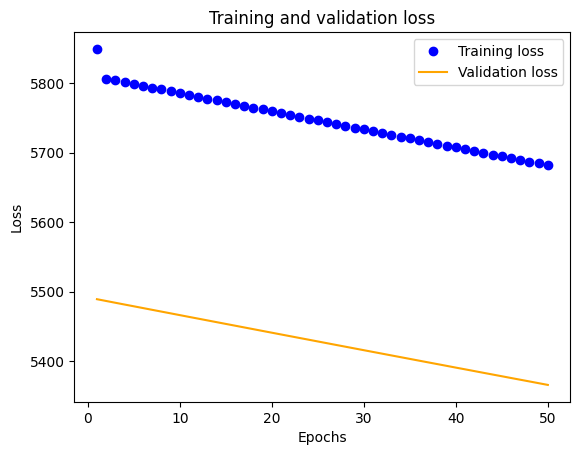

In [ ]:
import matplotlib.pyplot as plt

history_dict = history.history
loss_values = history_dict['loss'] # you can change this
val_loss_values = history_dict['val_loss'] # you can also change this
epochs = range(1, len(loss_values) + 1) # range of X (no. of epochs)
plt.plot(epochs, loss_values, 'bo', label='Training loss')
plt.plot(epochs, val_loss_values, 'orange', label='Validation loss')
plt.title('Training and validation loss')
plt.xlabel('Epochs')
plt.ylabel('Loss')
plt.legend()
plt.show()